In [134]:
import pandas as pd
import numpy as np

https://derivative.credit-suisse.com/ch/ch/en/detail/callable-brc-alphabet-apple-microsoft-11-00-p-a/CH1149492436/114949243

In [135]:
## Stock Split on GOOGL UW (Alphabet Inc. -A-). The 20 for 1 stock split was adjusted.
2461.48 / 20, 5000 / (2461.48 / 20)

(123.074, 40.62596486666558)

## Basic descriptions

In [136]:
denomination = 5000
barrier = 0.59
# being the date on which the Strike and the Barrier and the Ratio is fixed,
# and from which date the Complex Products may be traded
initial_fixing_date = "2022-04-25" 
final_fixing_date = "2023-07-26"
final_redemption_date = "2023-08-02"

issue_date = "2022-05-02"

coupon_rate = 0.11 / 4

coupon_payment_dates = [
    "2022-08-02",
    "2022-11-02",
    "2023-02-02",
    "2023-05-02",
    "2023-08-02"
]

exercise_dates = [
    "2022-10-26",
    "2023-01-26",
    "2023-04-25"
]

early_redemption_dates = [
    "2022-11-02",
    "2023-02-02",
    "2023-05-02"
]

stock_init_price = {
    "GOOGL":  2461.48 / 20,
    "AAPL": 162.88,
    "MSFT": 280.72
}

stock_ratio = {
    "GOOGL":  40.62596486666558,
    "AAPL": 30.6974,
    "MSFT": 17.8113
}

stock_names = ["GOOGL",	"MSFT",	"AAPL"]

In [137]:
## config
log = False

## Count Business days

In [138]:
def get_business_days_from_initial_date(cur_date, initial_date = issue_date):
    return np.busday_count(initial_date, cur_date)

def get_business_days_to_final_redemption(cur_date, final_date = final_redemption_date):
    return np.busday_count(cur_date, final_date)

In [139]:
print("coupon_payment_dates")
for date in coupon_payment_dates:
    print(date, ": ", get_business_days_from_initial_date(date))
    print("dates to marutre: ", get_business_days_to_final_redemption(date))

print("early_redemption_dates")
for date in early_redemption_dates:
    print(date, ": ", get_business_days_from_initial_date(date))
    print("dates to marutre: ", get_business_days_to_final_redemption(date))

coupon_payment_dates
2022-08-02 :  66
dates to marutre:  261
2022-11-02 :  132
dates to marutre:  195
2023-02-02 :  198
dates to marutre:  129
2023-05-02 :  261
dates to marutre:  66
2023-08-02 :  327
dates to marutre:  0
early_redemption_dates
2022-11-02 :  132
dates to marutre:  195
2023-02-02 :  198
dates to marutre:  129
2023-05-02 :  261
dates to marutre:  66


## Caculate interest rate discounted price

In [140]:
## dummy intesest rate func 
# (should return the average interest rate from current date to final redemption date)
def get_interest_rate(cur_date, to_date = final_redemption_date):
    return 0.03

def get_discounted_price(p: float, cur_date, to_date = final_redemption_date):
    r = get_interest_rate(cur_date)
    return p * np.exp(- r * np.busday_count(cur_date, to_date) / 250)

In [141]:
## simple test: how much is $100 one year later worth today?
get_discounted_price(100, "2022-11-07", "2023-11-07")

96.91653905244968

In [142]:
## p_mature should be the lowest total price of stocks
def get_product_price(p_mature, cur_date, next_date = final_redemption_date):
    coupon_remaining = 0.0
    for coupon_payment_date in coupon_payment_dates:
        if cur_date <= coupon_payment_date and coupon_payment_date < next_date:
            coupon_remaining += get_discounted_price(denomination * coupon_rate, cur_date, coupon_payment_date)
    d = get_discounted_price(p_mature, cur_date, final_redemption_date)
    return d + coupon_remaining


In [143]:
## How much is 5000 + 11% quarterly worth on issue_date?
get_product_price(5000, issue_date)

5346.885791063998

In [144]:
5000 * (1 + 0.11 * 1.25)

5687.5

## Redemption Amount

In [145]:
df_init_price = pd.Series(stock_init_price)
df_convert = pd.Series(stock_ratio)
df_init_price, df_convert


(GOOGL    123.074
 AAPL     162.880
 MSFT     280.720
 dtype: float64,
 GOOGL    40.625965
 AAPL     30.697400
 MSFT     17.811300
 dtype: float64)

In [146]:
## input: 
stock_names = ["GOOGL", "AAPL", "MSFT"]

def get_redemption_amount(df: pd.DataFrame):
    lowest_prices = df[stock_names].min()
    barrier_trigger = (lowest_prices / df_init_price < barrier).sum() 

    # if log:
    #     print("barrier_trigger", barrier_trigger)

    if barrier_trigger > 0:
        tmpdf = df.reset_index().set_index("date")
        stock_min = (tmpdf.loc[tmpdf.index.max(), stock_names] * df_convert).min()
        if log:
            print("stock_min", stock_min)
        return min(stock_min, denomination)
    else:
        return denomination


In [147]:
sample_path_df = pd.read_csv("../generated_data/sample_path.csv", index_col = "date")
df = sample_path_df
df

,GOOGL,MSFT,AAPL
date,,,
2022-07-22,113.602065,262.053037,153.942500
2022-07-25,114.735530,264.850739,155.106186
2022-07-26,111.220134,254.515022,148.911027
2022-07-27,108.008860,247.503351,144.744386
2022-07-28,103.235604,235.304339,137.725854
...,...,...,...
2023-07-20,74.088786,182.356124,127.010467
2023-07-21,73.337796,179.753237,126.103559
2023-07-24,68.467933,168.802990,117.956346


In [148]:
get_redemption_amount(sample_path_df)

2698.115894502515

In [149]:
get_product_price(get_redemption_amount(sample_path_df), cur_date = sample_path_df.index.min())

3155.8428358497395

In [150]:
3363.8576424803377 / 5000

0.6727715284960676

## Callable Feature

In [151]:
sample_sim_1000 = pd.read_csv("../generated_data/sample_sim_1000.csv", index_col=["index", "date"])
sample_sim_1000.reset_index(inplace=True)
sample_sim_1000 

,index,date,GOOGL,MSFT,AAPL
0,0,2022-07-22,115.448914,266.426132,155.975374
1,0,2022-07-25,112.925112,260.465917,152.309982
2,0,2022-07-26,113.138557,260.416992,152.366850
3,0,2022-07-27,111.856239,257.764593,150.462063
4,0,2022-07-28,115.917357,266.288019,155.022269
...,...,...,...,...,...
263995,999,2023-07-20,127.269997,296.520212,198.695519
263996,999,2023-07-21,129.441063,302.175223,202.513439
263997,999,2023-07-24,131.499261,307.031882,205.781609
263998,999,2023-07-25,130.433539,303.702342,203.195148


In [152]:
import statsmodels.api as sm

In [153]:
## y = a_0 + a_1 * x + a_2 * x ** 2
class Poly2DModel:
    
    mod: sm.OLS
    x_name: str
    
    def fit(self, df : pd.DataFrame, x_names: list, y_name: str):
        self.x_names = x_names.copy()
        self.df = df
        for x_name in self.x_names:
            self.df[x_name + "_sq"] = np.power(self.df[x_name], 2)
        
        self.x_names.extend([x_name + "_sq" for x_name in self.x_names])
            
        self.X = sm.add_constant(self.df[self.x_names])
        self.y = self.df[y_name]
        self.mod = sm.OLS(self.y, self.X).fit()

    def predict(self):
        self.df["pred"] = self.mod.predict()
        return self.mod.predict()

In [154]:
test_df = (
    sample_sim_1000[((sample_sim_1000["date"] == "2023-07-26") | (sample_sim_1000["date"] == "2022-08-02"))]
    [["index", "date", "GOOGL"]]
    .pivot(index = "index", columns = "date", values = "GOOGL")
)

<AxesSubplot:xlabel='2022-08-02', ylabel='pred'>

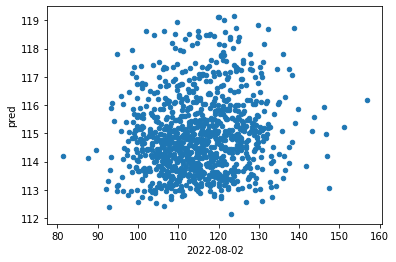

In [155]:
mod = Poly2DModel()
mod.fit(test_df, x_names = ["2023-07-26"], y_name="2022-08-02")
mod.predict()
mod.df.plot(x = "2022-08-02", y = "pred", kind= "scatter")

In [156]:
def get_sim_noncallable_price(df: pd.DataFrame):
    func_df = df.set_index(["index", "date"])
    l = []
    for i in  range(1000):
        tmp_df = func_df.loc[i]
        l.append(get_product_price(get_redemption_amount(tmp_df), cur_date = final_redemption_date))
        
    return pd.Series(l, index = pd.Series([x for x in range(1000)]))

In [157]:
final_prices = get_sim_noncallable_price(sample_sim_1000)

In [158]:
final_prices

0      3813.290597
1      5000.000000
2      5000.000000
3      2730.380134
4      1533.663143
          ...     
995    5000.000000
996    5000.000000
997    5000.000000
998    5000.000000
999    5000.000000
Length: 1000, dtype: float64

In [159]:
# input df: to get prices of underlying assets to run the regression
def get_v_backward(df: pd.DataFrame, exercise_date: str, redemption_date: str, v: pd.Series, v_date: str) -> pd.Series:
    discounted_v = v.apply(lambda x: get_discounted_price(x, redemption_date, v_date))
    mod = Poly2DModel()
    regress_input_df = (
        df.set_index(["date", "index"])
        .loc[exercise_date, stock_names]
    ).assign(discounted_v = discounted_v)

    mod.fit(regress_input_df, stock_names, "discounted_v")
    pred_v = mod.predict()

    return discounted_v.where((pred_v < denomination), other = denomination) + denomination * coupon_rate

In [160]:
final_prices = get_sim_noncallable_price(sample_sim_1000)

In [161]:
sample_sim_1000[stock_names]

,GOOGL,AAPL,MSFT
0,115.448914,155.975374,266.426132
1,112.925112,152.309982,260.465917
2,113.138557,152.366850,260.416992
3,111.856239,150.462063,257.764593
4,115.917357,155.022269,266.288019
...,...,...,...
263995,127.269997,198.695519,296.520212
263996,129.441063,202.513439,302.175223
263997,131.499261,205.781609,307.031882
263998,130.433539,203.195148,303.702342


In [162]:
v_date = final_redemption_date
v_price = get_sim_noncallable_price(sample_sim_1000)
cur_date = sample_sim_1000.date.min()
for i in range(len(exercise_dates) - 1, -1, -1):
    exercise_date = exercise_dates[i]
    redemption_date = early_redemption_dates[i]
    v_price = get_v_backward(sample_sim_1000, exercise_date, redemption_date, v_price, v_date)
    v_date = redemption_date


In [163]:
v_0_price = v_price.apply(lambda x: get_product_price(x, cur_date, next_date= v_date))

In [164]:
v_0_price.mean()

4503.215886177945

In [165]:
v_0_price.mean() / 5000

0.9006431772355891

In [167]:
np.sqrt(v_0_price.var())

1085.364580815775